In [1]:
!pip install opendatasets
# !pip install -U spacy -qq
!python -m spacy download en_core_web_sm
#!pip install xgboost


2023-09-11 09:17:10.396942: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 09:17:12.884223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [47]:
import opendatasets as od
import pandas as pd
import chardet
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np
import re
import os
from google.colab import drive
from bs4 import BeautifulSoup as bs
from pathlib import Path
from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay
import string
from textblob import TextBlob
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
import collections
import warnings
warnings.filterwarnings("ignore")

In [3]:
# if 'google.colab' in str(get_ipython()):
#   # from google.colab import drive
#   # drive.mount('/content/drive')
#   # base_folder = Path('/content/drive/MyDrive/Colab_Notebooks/NLP/') # MAKE SURE TO CHANGE THE PATH

# # (the else block is required only if you have local GPU machine, other wise you can ignore the else block)
# else:
#   base_folder = Path('/home/harpreet/Insync/google_drive_shaannoor/data') # MAKE SURE TO CHANGE THE PATH


In [4]:
# !cp '/content/drive/MyDrive/Colab_Notebooks/NLP/custom_preprocessor_mod.py' .
# !cp '/content/drive/MyDrive/Colab_Notebooks/NLP/featurizer.py' .
# !cp '/content/drive/MyDrive/Colab_Notebooks/NLP/plot_learning_curve.py' .

In [5]:
# import custom_preprocessor_mod as cp
# from featurizer import ManualFeatures
# from plot_learning_curve import plot_learning_curve

In [6]:
od.download("https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: shremuk
Your Kaggle Key: ··········


100%|██████████| 211k/211k [00:00<00:00, 54.2MB/s]

In [7]:
# with open(file, 'rb') as rawdata:
#     result = chardet.detect(rawdata.read(100000))
# result

# **Reading the file**

In [8]:
file =('sms-spam-collection-dataset/spam.csv')
df = pd.read_csv('sms-spam-collection-dataset/spam.csv', encoding = 'Windows-1252') # delimiter = ',', encoding="latin1"
df.rename(columns = {'v1':'labels', 'v2': 'message'}, inplace = True)
df.drop({'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'}, axis = 1, inplace = True)
df = df[['message', 'labels']]
df.labels.replace({'spam': 1, 'ham': 0}, inplace = True)
df['message'] = [bs(text).getText() for text in df.message]

<ipython-input-8-8e141cc8bd3c>:7: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  df['message'] = [bs(text).getText() for text in df.message]


In [9]:
df.head()

,message,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [10]:
df.isna().sum()

message    0
labels     0
dtype: int64

In [11]:
df.shape[0]

5572

**% Ham and spam in the dataset**

In [12]:
round(df.labels.value_counts(normalize = True) * 100, 3)

0    86.594
1    13.406
Name: labels, dtype: float64

# **Choice of accuracy metric**

**Since importance needs to be given to the correct classification for spam(class 1) hence I'd go ahead with recall score. Will try to maximize recall for this dataset. However, will also check the f1 score so that at the end, it balances precision and recall**

# **Splitting into train and test**

In [13]:
X = df.message
y = df['labels']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 66)

**Picking up samples for GRIDSEARCHCV - 20% of train dataset**

In [14]:
X_train_sample = X_train.sample(n = 150, replace=True, random_state=1)
y_train_sample = y_train.sample(n = 150, replace=True, random_state=1)
print(X_train_sample.shape, y_train_sample.shape)

(150,) (150,)


# **Vectorization**

**TF-IDF Vectorization**

In [15]:
# tf = TfidfVectorizer()
# tf_vectors = tf.fit_transform(X_train.message)
# #print(tf_vectors.toarray())

**Printing tf-idf matrix**

In [16]:
# tf_df = pd.DataFrame(tf_vectors.toarray(), columns = tf.get_feature_names_out())
# tf_df.head()

In [17]:
# term_idf = tf.idf_
# df_idf = pd.DataFrame(term_idf, index=tf.get_feature_names_out())
# df_idf.round(4).T

# **Round 1: First pipeline using only Sparse embedding(TF-IDF matrix)**

In [48]:
xg = XGBClassifier()
classifier = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", ngram_range = (1, 2))), \
                       ('model', xg)])  #n_estimators=100, learning_rate = 0.1
params_class1 = {'model__max_depth': range(1, 10, 1), 'model__n_estimators':[100, 300, 500], 'model__eta': [0.001, 0.01, 0.05, 0.1, 1]}
gs1 = HalvingGridSearchCV(estimator=classifier, param_grid = params_class1, scoring = 'roc_auc', cv = 5)
model1 = gs1.fit(X_train_sample, y_train_sample)
print(f'Best cross-validation score: {model1.best_score_:.2f}')
print("\nBest parameters: ", model1.best_params_)
print("\nBest estimator: ", model1.best_estimator_)

Best cross-validation score: 0.85

Best parameters:  {'model__eta': 0.01, 'model__max_depth': 2, 'model__n_estimators': 500}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), token_pattern='[\\S]+')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.01,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_

**Using best params from GridSearchCV to fit them on complete X_train**

In [19]:
pipe = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", ngram_range = (1, 2))), \
                       ('model', XGBClassifier(eta = 0.1, max_depth = 2, n_estimators = 500))])
class_fit = pipe.fit(X_train, y_train)
y_pred_round1 = class_fit.predict(X_test)
pipe.score(X_test, y_test)

0.9617224880382775

In [20]:
print(classification_report(y_test, y_pred_round1))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1444
           1       0.98      0.73      0.84       228

    accuracy                           0.96      1672
   macro avg       0.97      0.87      0.91      1672
weighted avg       0.96      0.96      0.96      1672



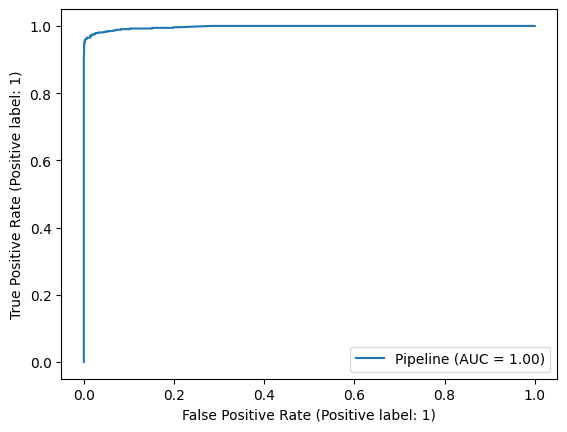

In [21]:
RocCurveDisplay.from_estimator(pipe, X_train, y_train)

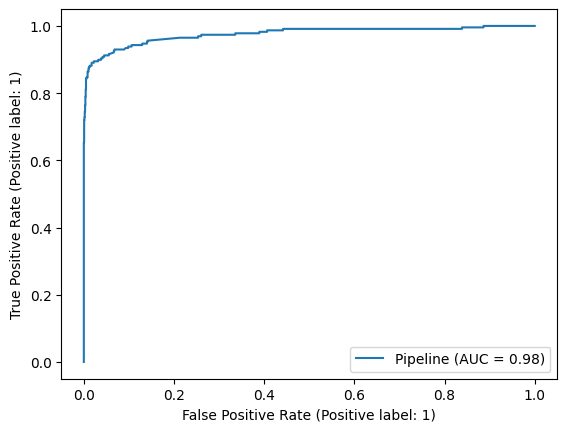

In [22]:
RocCurveDisplay.from_estimator(pipe, X_test, y_test)

# **Round 2: With Feature Engineering - Data Preprocessing + Manual Features + ML Model pipeline**

In [23]:
df.head()

,message,labels
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [24]:
df.message = df.message.str.replace(r"^.+@.+\.{2,}$", '')
df.message = df.message.str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip() #apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df.message = df.message.str.replace('[{}]'.format(string.punctuation), '')
df.message = df.message.str.replace(r'[\"\\...\\\n]', '')
df.message = df.message.str.replace(r'[...]', ' ')

<ipython-input-24-eb6e7a6e2216>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.message = df.message.str.replace(r"^.+@.+\.{2,}$", '')
<ipython-input-24-eb6e7a6e2216>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df.message = df.message.str.replace(r'\s*https?://\S+(\s+|$)', '').str.strip() #apply(lambda x: re.split('https:\/\/.*', str(x))[0])
<ipython-input-24-eb6e7a6e2216>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df.message = df.message.str.replace('[{}]'.format(string.punctuation), '')
<ipython-input-24-eb6e7a6e2216>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df.message = df.message.str.replace(r'[\"\\...\\\n]', '')
<ipython-input-24-eb6e7a6e2216>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df.message = df.messa

In [25]:
df['Word_count'] = df.message.str.split().str.len()
df['Character_count'] = df.message.str.len()
df['Character_count_wo_space'] = df.message.str.replace('\s', '', regex=True).str.len()
df['average_word_length'] = df.message.apply(lambda x: np.mean([len(w) for w in x.split()])).round(3)
df['count_of_digits'] = df.message.str.split().str.isdigit().sum()
df['extract_nos'] = df.message.str.findall(r'(\d+)').str.len()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [26]:
nlp = spacy.load("en_core_web_sm")
def count_noun(x):
  res = [token.pos_ for token in nlp(x)]
  return collections.Counter(res)['NOUN']

In [27]:
df['noun'] = df.message.map(count_noun)
# df['nouns'] = df.message.map(lambda x: proper_noun_extraction(x)).to_list()
# df['noun_count'] = len(df['nouns'])
# df.head()

In [28]:
# def get_adjectives(text):
#   blob = TextBlob(text)
#   return [ word for (word,tag) in blob.tags if tag == "JJ"]

# df['adjectives'] = df.message.apply(get_adjectives)

In [29]:
df.head()

,message,labels,Word_count,Character_count,Character_count_wo_space,average_word_length,count_of_digits,extract_nos,noun
0,Go until jurong point crazy Available only in ...,0,20,102,83,4.150,0.0,0,3
1,Ok lar Joking wif u oni,0,6,23,18,3.000,0.0,0,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,149,122,4.357,0.0,6,8
3,U dun say so early hor U c already then say,0,11,43,33,3.000,0.0,0,5
4,Nah I dont think he goes to usf he lives aroun...,0,13,59,47,3.615,0.0,0,0


### **Splitting into train and test**

In [30]:
X_round2 = df.drop(['message', 'labels'], axis = 1)
y_round2 = df['labels']
X_train_round2, X_test_round2, y_train_round2, y_test_round2 = train_test_split(X_round2, y_round2, test_size = 0.3, random_state = 66)

### **Take 150 samples from the dataset to get the best params**

In [31]:
X_train_sample2 = X_train_round2.sample(n = 150, replace=True, random_state=1)
y_train_sample2 = y_train_round2.sample(n = 150, replace=True, random_state=1)
print(X_train_sample2.shape, y_train_sample2.shape)

(150, 7) (150,)


**Fitting the Pipeline**

In [32]:
pipe2 = Pipeline([('model', XGBClassifier())])
params_2 = {'model__max_depth': range(1, 10, 1), 'model__n_estimators':[100, 300, 500], 'model__eta': [0.001, 0.01, 0.05, 0.1, 1]}
random = HalvingGridSearchCV(pipe2, params_2, random_state=10).fit(X_train_sample2, y_train_sample2)
print(f'Best cross-validation score: {random.best_score_:.2f}')
print("\nBest parameters: ", random.best_params_)
print("\nBest estimator: ", random.best_estimator_)

Best cross-validation score: 0.95

Best parameters:  {'model__eta': 0.001, 'model__max_depth': 1, 'model__n_estimators': 500}

Best estimator:  Pipeline(steps=[('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.001,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=1, max_leaves=None,
          

**Fitting on complete train data**

In [33]:
pipe2 = Pipeline([('model', XGBClassifier(eta = 0.05, max_depth = 2, n_estimators = 500))])
pipe2_fit = pipe2.fit(X_train_round2, y_train_round2)

In [34]:
y_pred_round2 = pipe2_fit.predict(X_test_round2)

In [35]:
print(classification_report(y_test_round2, y_pred_round2))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1444
           1       0.91      0.83      0.87       228

    accuracy                           0.97      1672
   macro avg       0.94      0.91      0.93      1672
weighted avg       0.97      0.97      0.97      1672



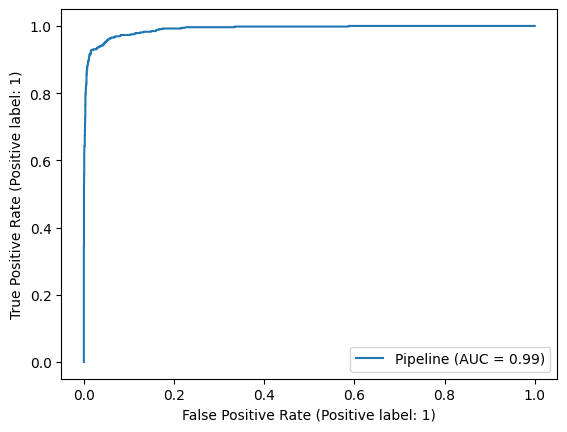

In [36]:
RocCurveDisplay.from_estimator(pipe2, X_train_round2, y_train_round2)

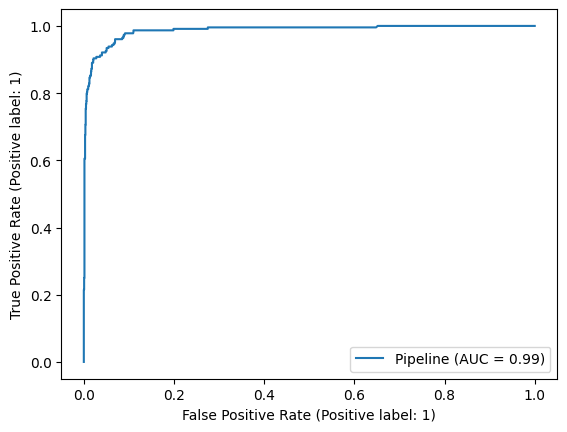

In [37]:
RocCurveDisplay.from_estimator(pipe2, X_test_round2, y_test_round2)

## **ROUND 3: Combine Manual Features and TfID vectors**

#### **Creating the dataframe with Sparse embedding and feature engineering**

In [38]:
df.head()

,message,labels,Word_count,Character_count,Character_count_wo_space,average_word_length,count_of_digits,extract_nos,noun
0,Go until jurong point crazy Available only in ...,0,20,102,83,4.150,0.0,0,3
1,Ok lar Joking wif u oni,0,6,23,18,3.000,0.0,0,2
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,149,122,4.357,0.0,6,8
3,U dun say so early hor U c already then say,0,11,43,33,3.000,0.0,0,5
4,Nah I dont think he goes to usf he lives aroun...,0,13,59,47,3.615,0.0,0,0


Splitting into train and text

In [39]:
X_final = df.drop('labels', axis = 1)
y_final = df['labels']
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X, y, test_size = 0.3, random_state = 30)

### **Picking up 200 samples**

In [40]:
X_final_sample = X_train_final.sample(n = 200, replace=True, random_state=10)
y_final_sample = y_train_final.sample(n = 200, replace=True, random_state=10)
print(X_final_sample.shape, y_final_sample.shape)

(200,) (200,)


### **Creating Pipeline to run the samples**

In [41]:
pipe3 = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", ngram_range = (1, 2))), \
                       ('model', XGBClassifier(n_estimators=100, learning_rate = 0.1))])

In [42]:
params = {'model__max_depth': range(1, 10, 1), 'model__n_estimators':[100, 300, 500], 'model__eta': [0.001, 0.01, 0.05, 0.1, 1]}
gsfinal = GridSearchCV(estimator = pipe3, param_grid = params, scoring = 'roc_auc', cv = 5)
model_final = gsfinal.fit(X_final_sample, y_final_sample)
print(f'Best cross-validation score: {model_final.best_score_:.2f}')
print("\nBest parameters: ", model_final.best_params_)
print("\nBest estimator: ", model_final.best_estimator_)

Best cross-validation score: 0.96

Best parameters:  {'model__eta': 0.001, 'model__max_depth': 2, 'model__n_estimators': 100}

Best estimator:  Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2), token_pattern='[\\S]+')),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.001,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat

### **Fitting the best params on the whole dataset**

In [43]:
pipe4 = Pipeline([('vectorizer', TfidfVectorizer(analyzer='word', token_pattern=r"[\S]+", ngram_range = (1, 2))), \
                  ('model', XGBClassifier(n_estimators=500, learning_rate = 0.001, max_depth = 2))])
result = pipe4.fit(X_train_final, y_train_final)
y_pred_final = result.predict(X_test_final)

In [44]:
print(classification_report(y_test_final, y_pred_final))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1465
           1       0.91      0.55      0.69       207

    accuracy                           0.94      1672
   macro avg       0.93      0.77      0.83      1672
weighted avg       0.94      0.94      0.93      1672



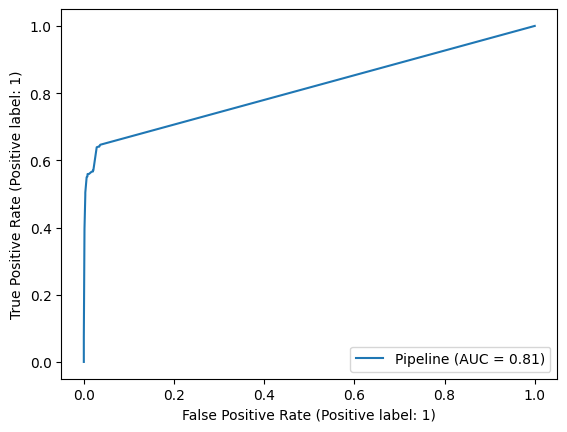

In [45]:
RocCurveDisplay.from_estimator(pipe4, X_train_final, y_train_final)

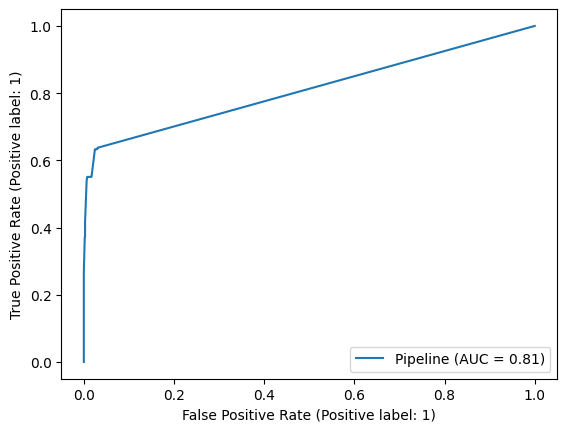

In [46]:
RocCurveDisplay.from_estimator(pipe4, X_test_final, y_test_final)